# MiniProject - Variant 3 - Group M

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

import sklearn
from sklearn.preprocessing import StandardScaler
import time
# import mat73 # requires pip install mat73

import pandas as pd
from align import align

from sklearn.decomposition import PCA, FastICA, NMF

from tqdm.notebook import tqdm
import gdown

## Loading data

<span style="color:orange">**Warning: this will slow down really hard your computer**</span>

In [6]:
# !pip install gdown

In [7]:
# import gdown

# url = "https://drive.google.com/uc?id=1fhX5gCvmqkFrQ_Um9WXzYdmDUCXadzrJ"
# output = "sub/s1.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1fhc-JCSnzE_oDOMszP9FsgmpxFUFAwYP"
# output = "sub/s2.mat"
# gdown.download(url, output, quiet = False)

# url = "https://drive.google.com/uc?id=1yWCwEKDaa97ZD44t1tS8i1IOJ5GIbROp"
# output = "sub/s3.mat"
# gdown.download(url, output, quiet = False)

In [8]:
n_subject = 3   

sub_files = []
for i in range(1, n_subject+1):
    sub_files.append(loadmat('sub/s' + str(i) + '.mat'))
    print("The type of the file nb " + str(i) + " is: " + str(type(sub_files[i-1])))
    print("The keys of the file nb " + str(i) + " are: " + str(sub_files[i-1].keys()))
    print("\n\n")

The type of the file nb 1 is: <class 'dict'>
The keys of the file nb 1 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 2 is: <class 'dict'>
The keys of the file nb 2 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])



The type of the file nb 3 is: <class 'dict'>
The keys of the file nb 3 are: dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])





Note for us: They say the signals were captured on 128 channels. From my understanding, its 64 channels on EMG_extensors, and 64 channels on EMG_flexors 

In [9]:
print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_class_new"]))))
print("number of uniques: " + str(len(np.unique(sub_files[0]["adjusted_repetition_new"]))))
print("number of uniques: " + str(sub_files[0]['emg_flexors_new'].shape))

number of uniques: 31
number of uniques: 6
number of uniques: (3000000, 8, 8)


## Part 1

### Preprocessing the data


In [10]:
# print(f'What are the shape of the data that we are working with? EMG_extensors: {emg_extensors.shape}, EMG_flexors {emg_flexors.shape}, adjusted_epetition {adjusted_repetition.shape}')

The movement should be the stimuli. We know there are 65 movements + 1 for the resting state, and the only keys to have 66 unique elements are `adjusted_class` and `class`, which correspondonds to the data description in https://www.nature.com/articles/s41597-021-00843-9

<span style="color:orange">check if adjusted_XXX are preprocessed for better correspondance to real movement or not</span>

<span style="color:orange">**WARNING: This will also slow down your computer**</span>

<span style="color:orange">**WARNING: I may be using incorrectly the number of channels**</span>

<span style="color:orange">**WARNING: Maybe we need to remove the outliers, thanks to the corresponding key**</span>

<span style="color:red">**ERROR: Laptop on fire 🔥**</span>


In [11]:
def preprocess_data(sub, sub_files, Wn=(5,500), N=4):
    Fs = sub_files[sub]['Fs'][0,0].copy()
    adjusted_class = sub_files[sub]['adjusted_class_new'].copy()
    adjusted_repetition = sub_files[sub]['adjusted_repetition_new'].copy()
    emg = sub_files[sub]['emg_flexors_new'].copy()
       
    # n_repetitions = len(np.unique(adjusted_repetition)) - 1 # -1 because 0 is not a repetition
    # n_stimuli = len(np.unique(adjusted_class)) - 1 # -1 because 0 is not a repetition
    n_channels = emg.shape[1]*emg.shape[2]

    emg = emg.reshape(emg.shape[0], n_channels)
    # print(f'How many types of movement are there? {n_stimuli}') 
    # print(f'How many repetitions are there? {n_repetitions}') 
    
    sos = butter(N=N, fs=Fs, Wn=Wn, btype="bandpass", output="sos")
    emg_filtered = sosfiltfilt(sos, emg)
    
    # Easier method to compute the envelope 

    emg_subsampled = emg_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
    emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

    weights = np.ones(200)
    emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
    
    return emg_envelope_200, adjusted_class, adjusted_repetition

In [12]:
emg_flexors_envelope_200, adjusted_class, adjusted_repetition = preprocess_data(sub=0, sub_files=sub_files)

### Visualizing the data

In [ ]:
# #lets take a quick look at the data

# fig, ax = plt.subplots(8, 1, figsize=(15, 16))
# for i in range(8):
#     ax[i].plot(emg_flexors_envelope_200[:100000, i])
#     ax[i].set_title("Channel {}".format(i))
#     ax[i].set_xlabel("Time (samples)")
#     ax[i].set_ylabel("Envelope")

# plt.tight_layout()

## Part 2

*Compute the spatial synergies using different blind source separation algorithms
(e.g. PCA, ICA, NMF). Are the synergies stable?*

### Spatial synergies using BSS

### NMF

In [ ]:
# For now let's just use 3 components. Parameters: init="nndsvda", max_iter=500.
nmf = NMF(n_components=3, init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_nmf = nmf.fit_transform(emg_flexors_envelope_200)
H_nmf = nmf.components_

Elapsed time:  23.88029193878174


In [ ]:
def plot_synergies(envelope, H, W, title=None):
    
    # Plot synthetic EMG data
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(envelope)
    plt.title('EMG envelope')
    plt.xlabel('Time')
    plt.ylabel('EMG Signal')

    # Plot extracted synergies
    plt.subplot(3, 1, 2)
    plt.plot(H.T)
    plt.title('Extracted Muscle Synergies')
    plt.xlabel('Channels')
    plt.ylabel('Synergy Value')

    # Plot extracted activation coefficients
    plt.subplot(3, 1, 3)
    plt.plot(W)
    plt.title('Extracted Activation Coefficients')
    plt.xlabel('Time')
    plt.ylabel('Activation Level')
    
    if title is not None:
        plt.suptitle(title)

    plt.tight_layout()

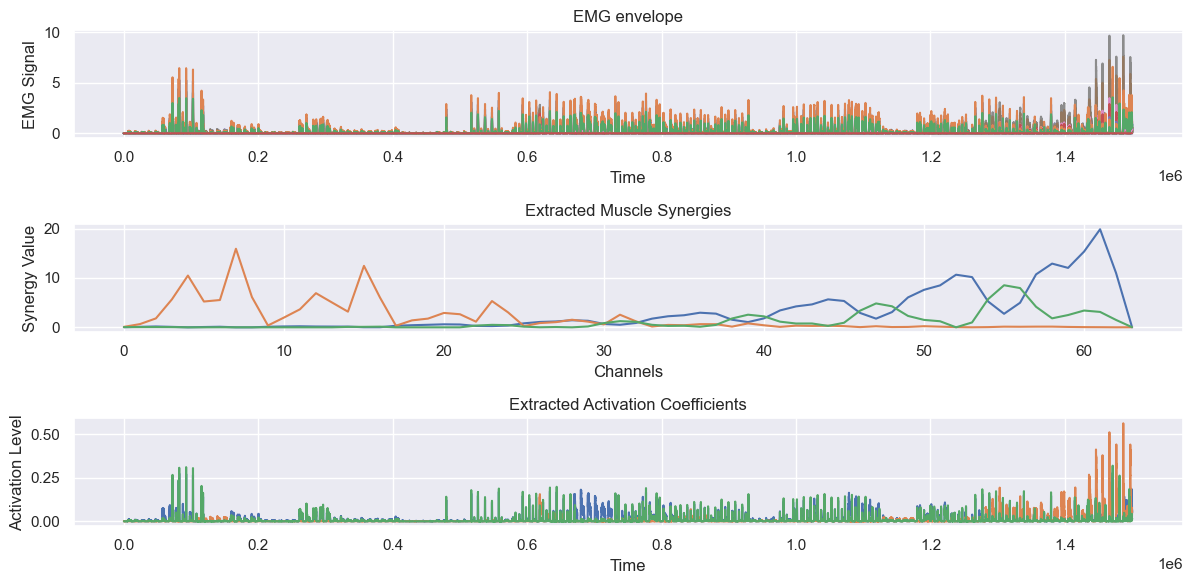

In [ ]:
plot_synergies(emg_flexors_envelope_200, H_nmf, W_nmf)

### PCA

In [ ]:
pca = PCA(n_components=3)

t = time.time()
pca.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use pca.fit_transform (W) and pca.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_pca = pca.fit_transform(emg_flexors_envelope_200)
H_pca = pca.components_

Elapsed time:  9.537516117095947


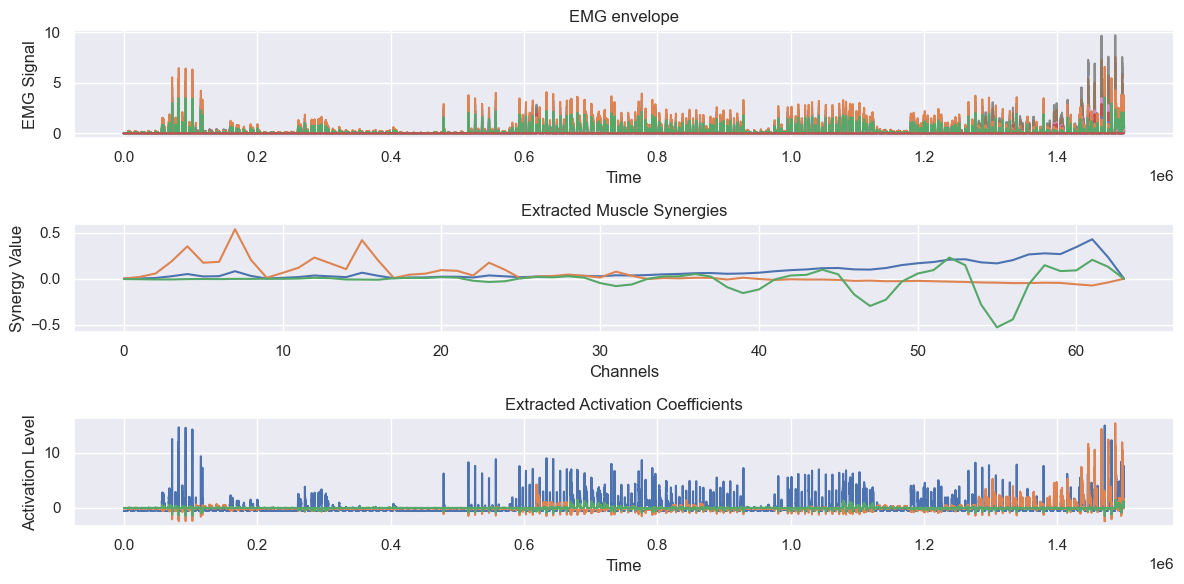

In [ ]:
# Plot synthetic EMG data

plot_synergies(emg_flexors_envelope_200, H_pca, W_pca)  

### ICA

In [ ]:
ica = FastICA(n_components=3)

t = time.time()
ica.fit(emg_flexors_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use ica.transform (W) and ica.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W_ica = ica.transform(emg_flexors_envelope_200)
H_ica = ica.components_

Elapsed time:  9.408682584762573


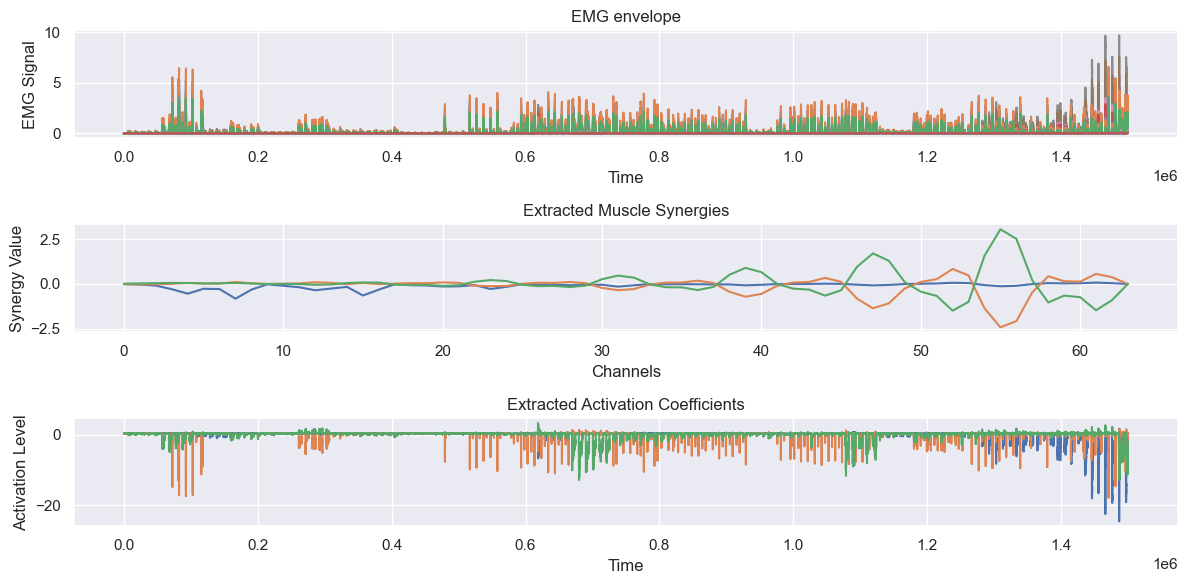

In [ ]:
# Plot synthetic EMG data
plot_synergies(emg_flexors_envelope_200, H_ica, W_ica)

## Part 3

*Compute the spatial synergies corresponding to different subsets of the data
samples. Are the synergies stable across the different subsets?*

### Comparaison



In [ ]:
n_subsets: int = 10
BSS = "NMF"

if BSS == "NMF":
    model = NMF(n_components=3, init="nndsvda", max_iter=500)
elif BSS == "PCA":
    model = PCA(n_components=3) 
elif BSS == "ICA":
    model = FastICA(n_components=3)
    
W_sub: list = []
H_sub: list = []
interval: int = int(emg_flexors_envelope_200.shape[0]/n_subsets)

for i in range(n_subsets):
    model.fit(emg_flexors_envelope_200[i*interval:(i+1)*interval])
    
    W_sub.append(model.fit_transform(emg_flexors_envelope_200[i*interval:(i+1)*interval]))
    H_sub.append(model.components_)

c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(
c:\Users\APrap\.conda\envs\NSSP\Lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.w

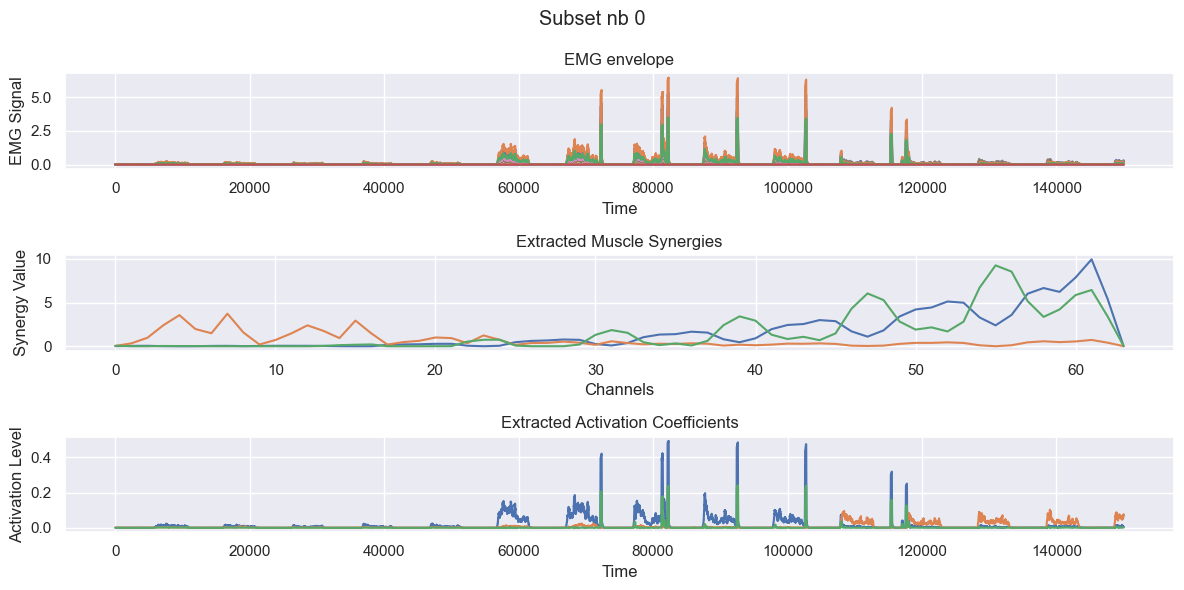

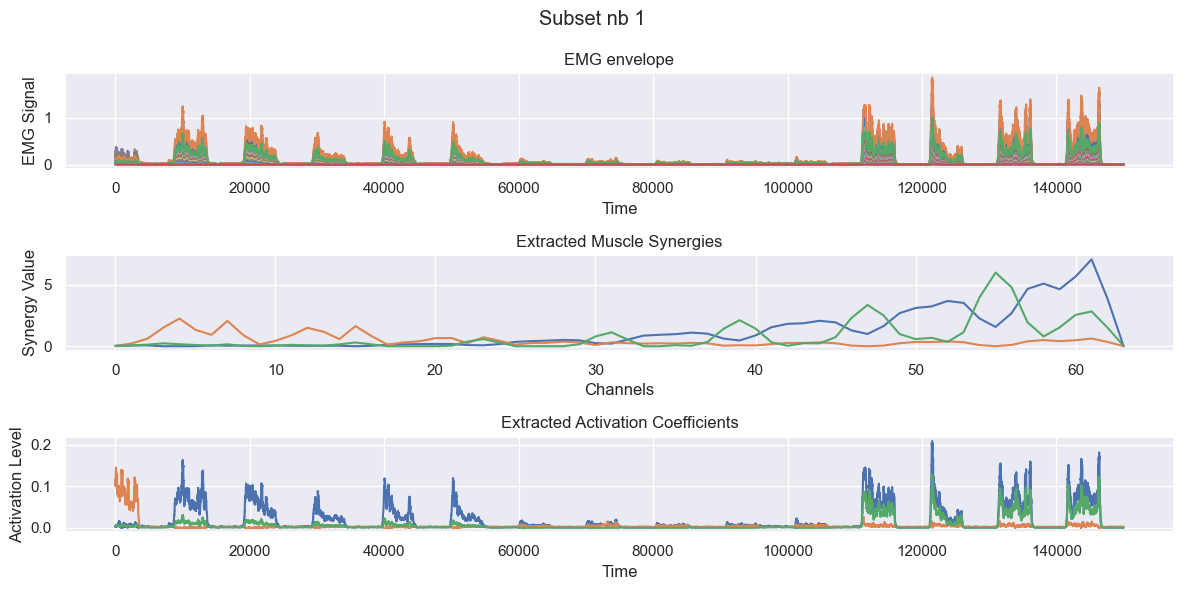

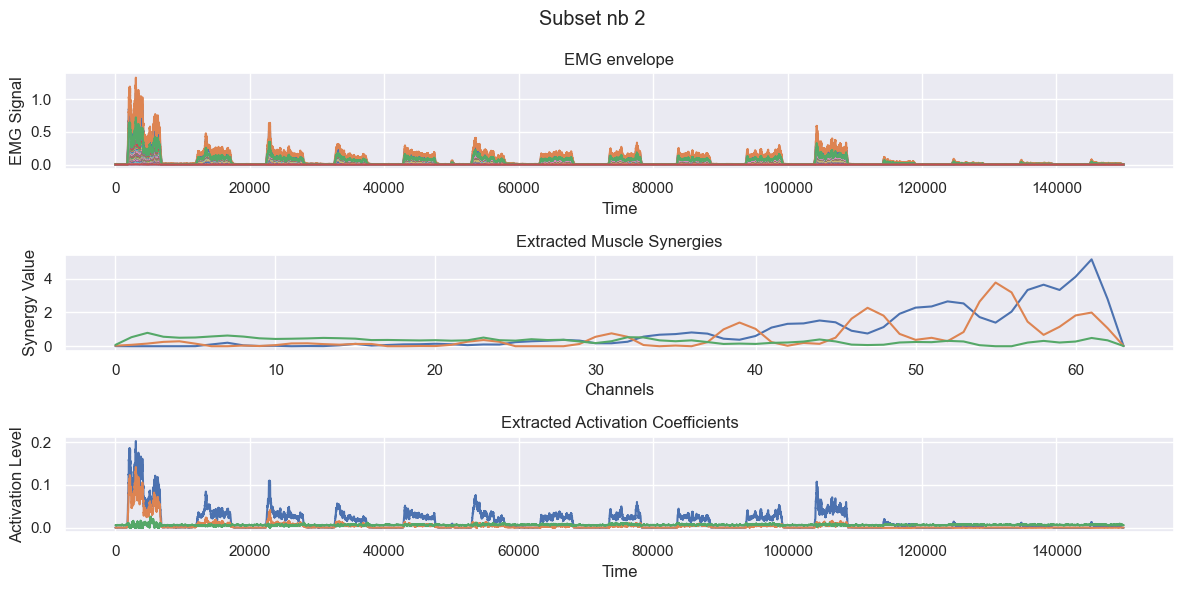

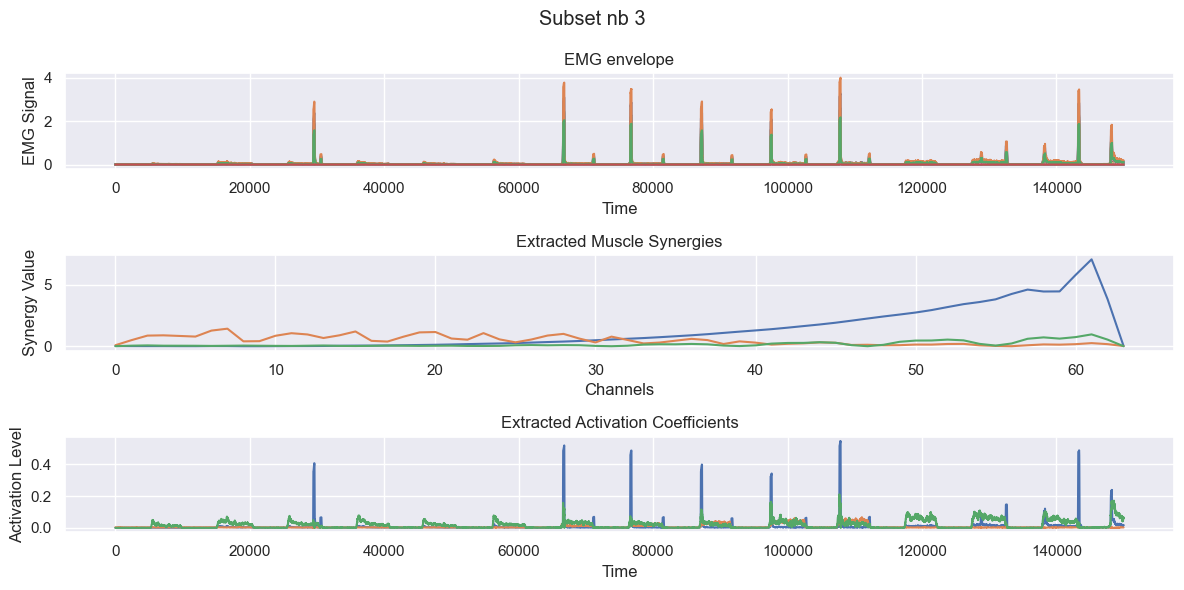

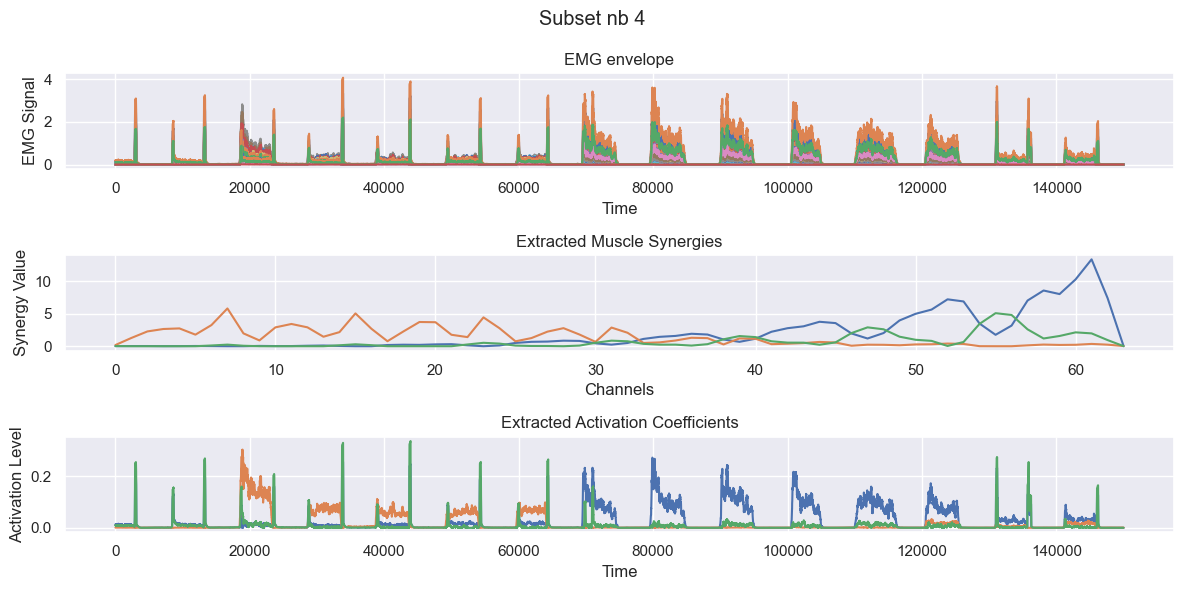

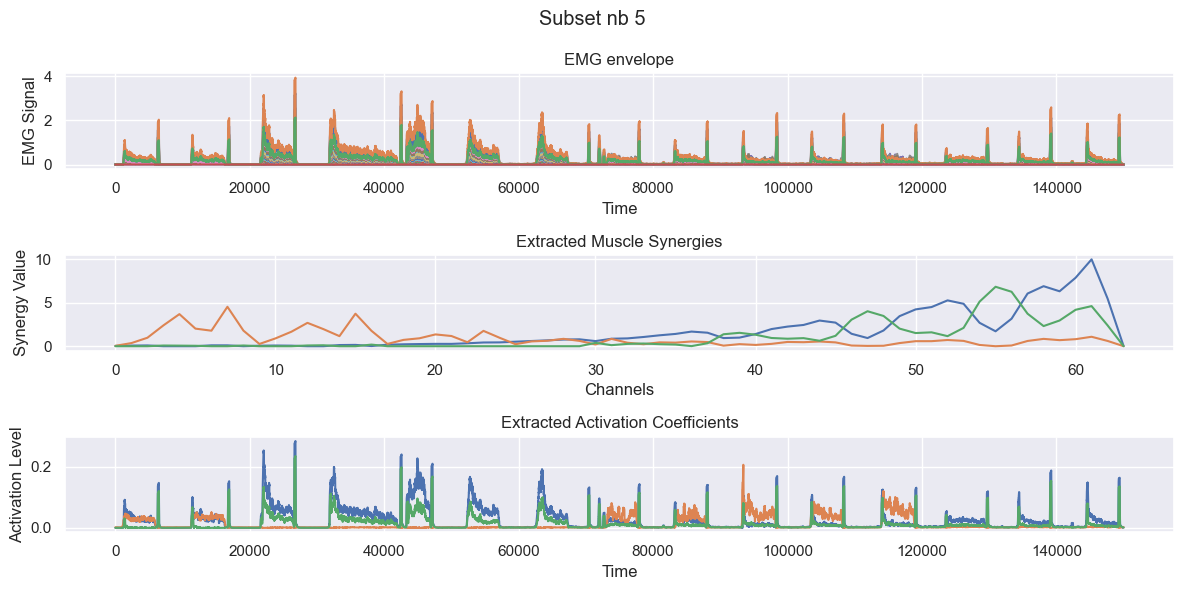

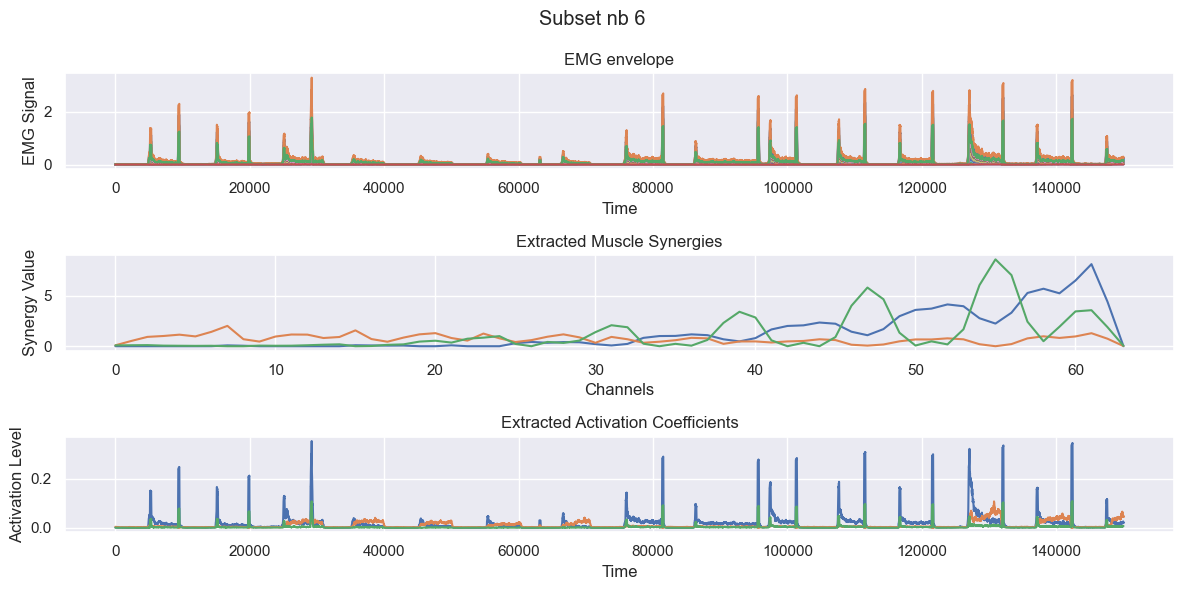

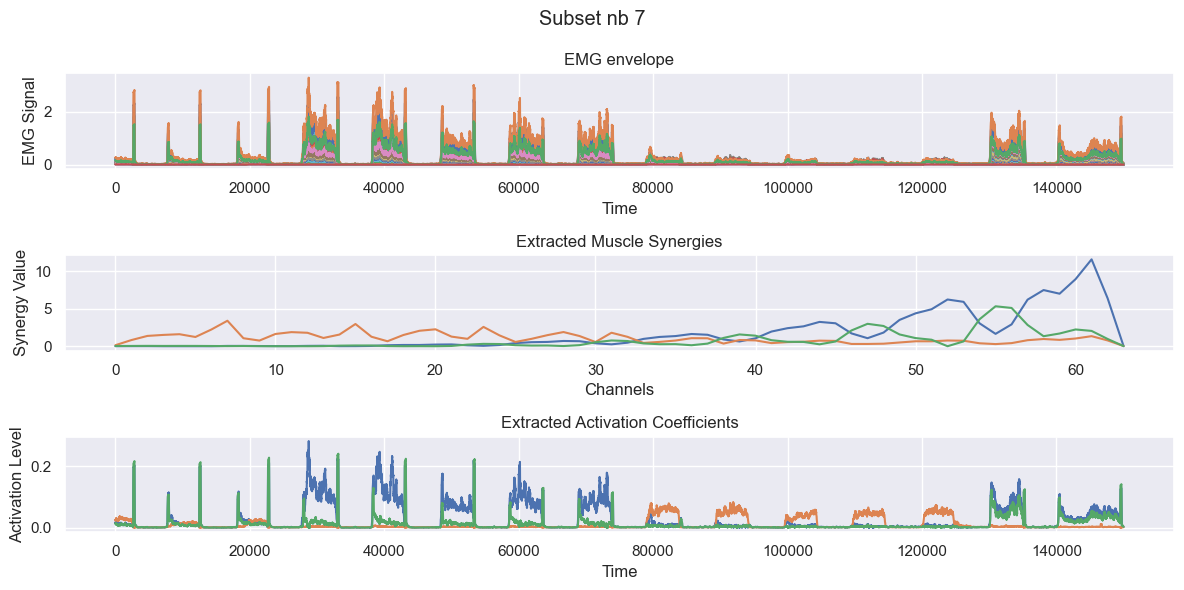

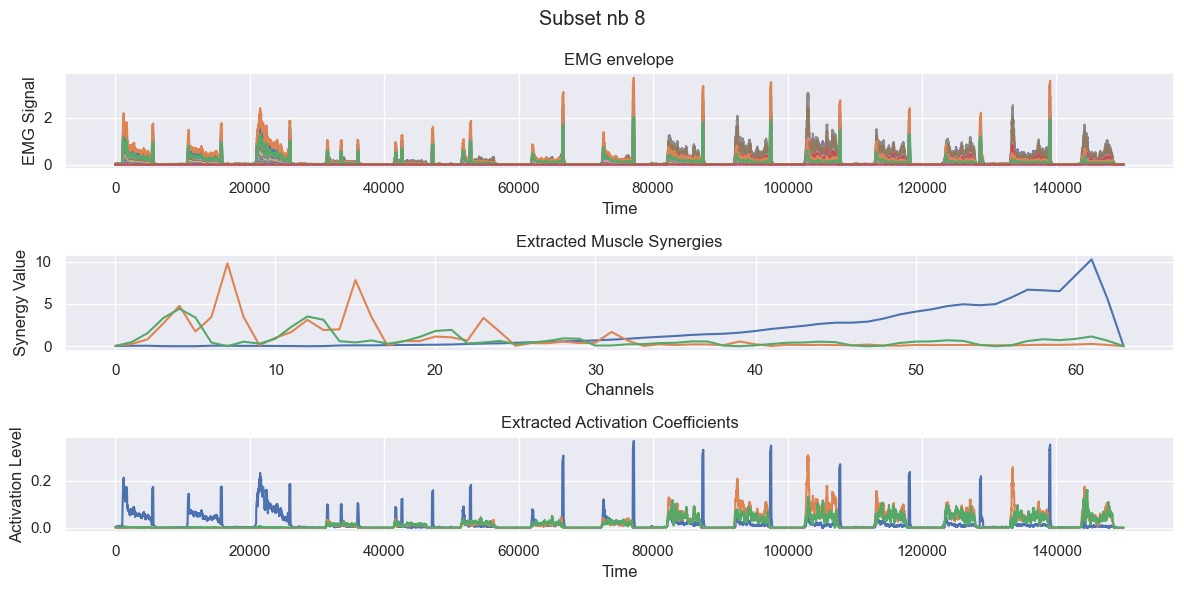

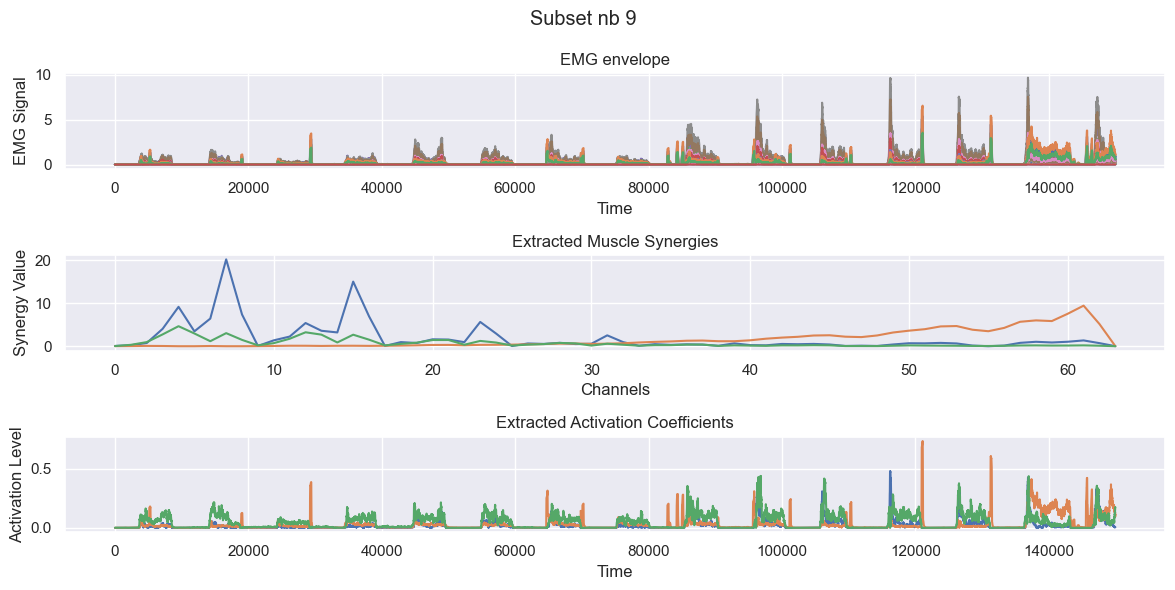

In [ ]:
for i in range(n_subsets):
    plot_synergies(emg_flexors_envelope_200[i*interval:(i+1)*interval], H_sub[i], W_sub[i], "Subset nb {}".format(i+1))

## Part 4
<span style="color:green">
 *Compute the spatial synergies for different subjects. Is it now stable across the
different subjects?* </span>


In [ ]:
n_subject: int = 3
BSS = "NMF"
 
W_subject: list = []
H_subject: list = []
envelope_subject: list = []

 
for i in range(n_subject):

    emg_envelope, adjusted_class, adjusted_repetition = preprocess_data(sub=i, sub_files=sub_files)
    envelope_subject.append(emg_envelope)
    
    if BSS == "NMF":
        model = NMF(n_components=3, init="nndsvda", max_iter=500)
    elif BSS == "PCA":
        model = PCA(n_components=3) 
    elif BSS == "ICA":
        model = FastICA(n_components=3)
    model.fit(emg_envelope)
    
    W_subject.append(model.fit_transform(emg_envelope))
    H_subject.append(model.components_)

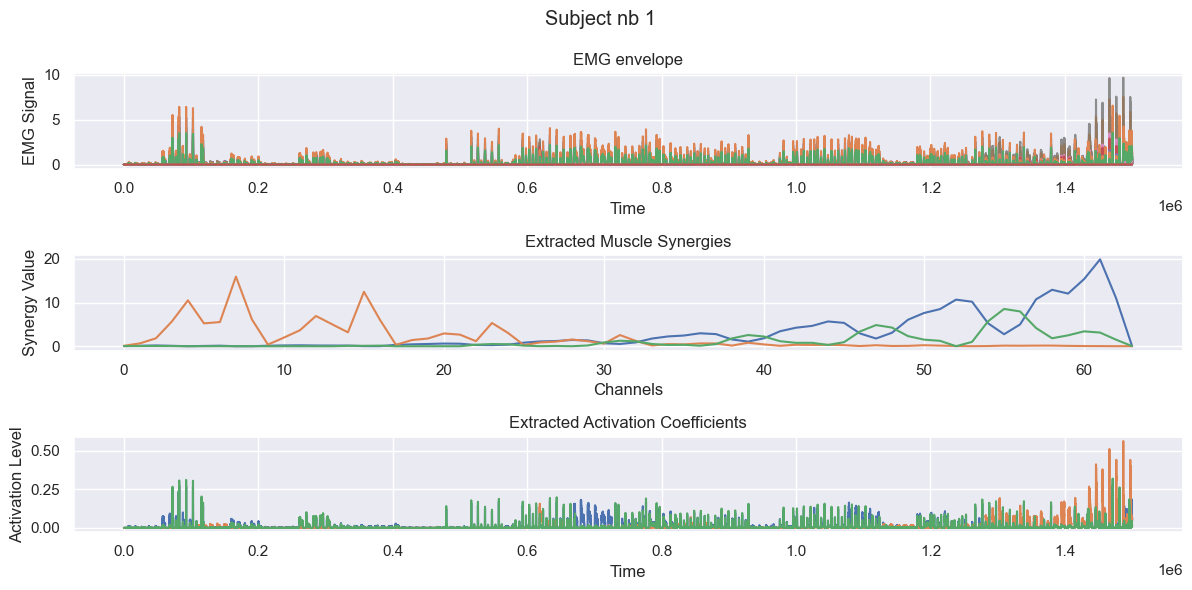

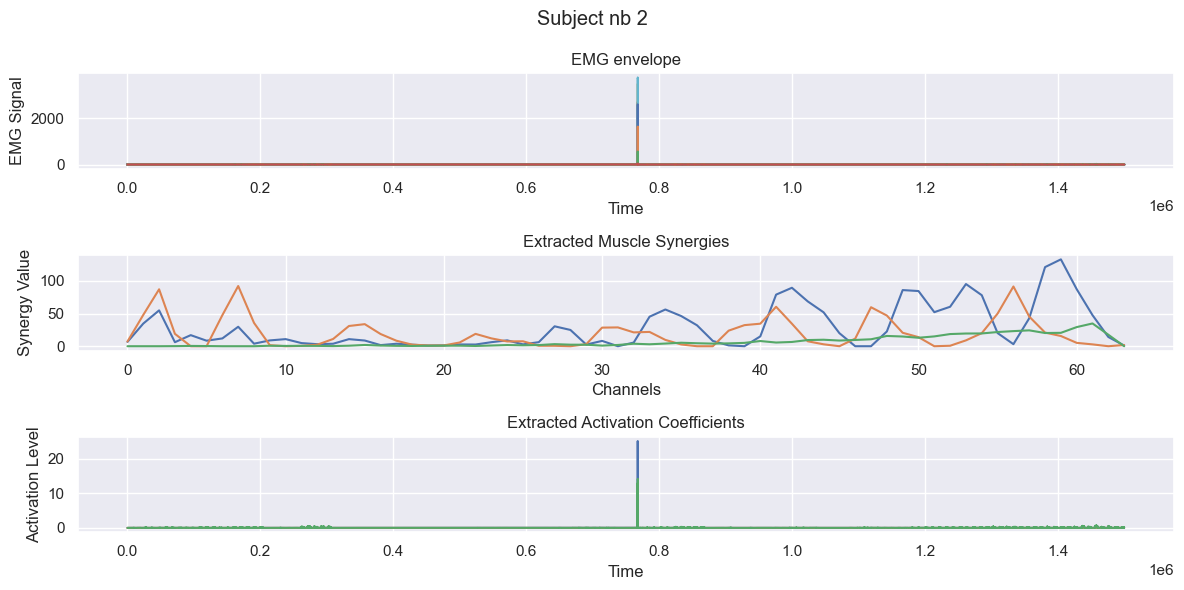

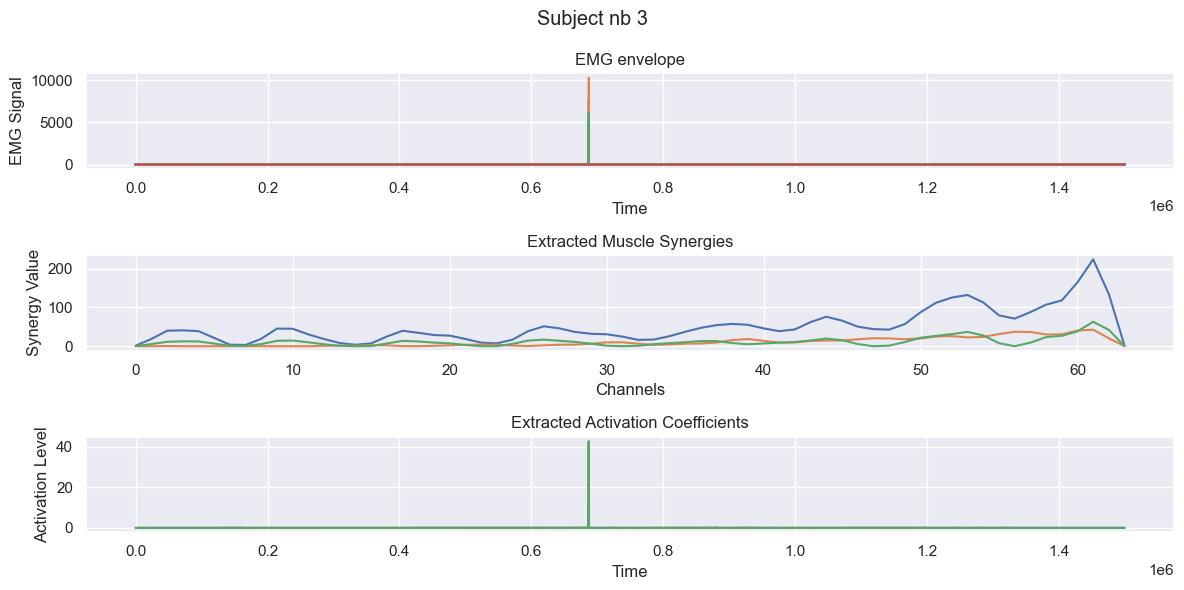

In [ ]:
for i in range(n_subject):
    plot_synergies(envelope_subject[i], H_subject[i], W_subject[i], "Subject nb {}".format(i+1))

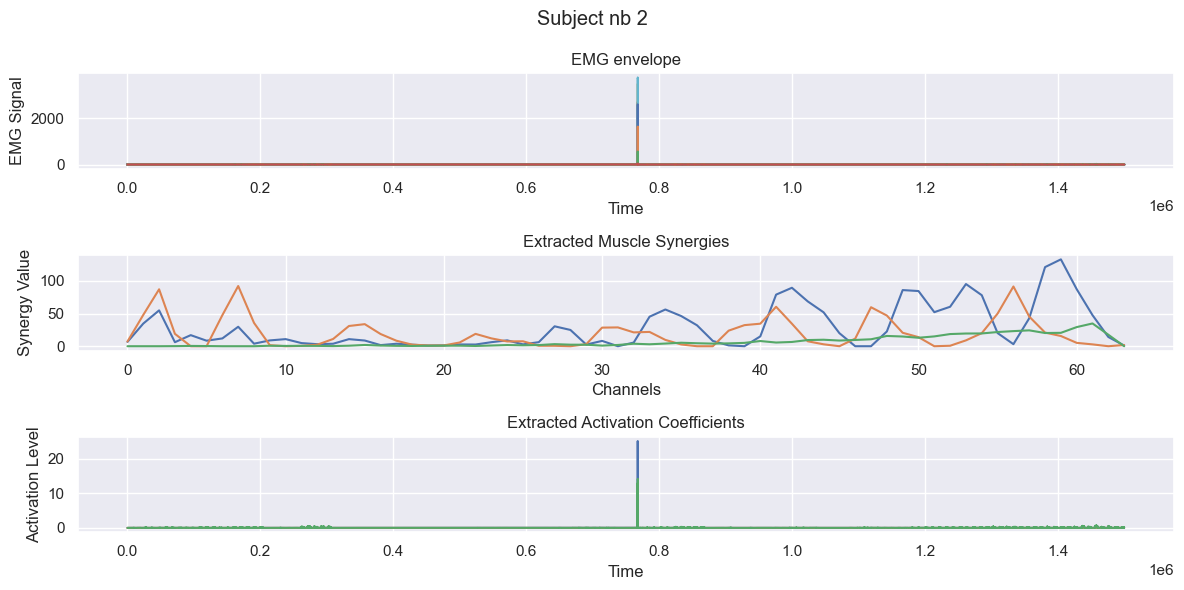

In [ ]:
i = 1
plot_synergies(envelope_subject[i], H_subject[i], W_subject[i], "Subject nb {}".format(i+1))


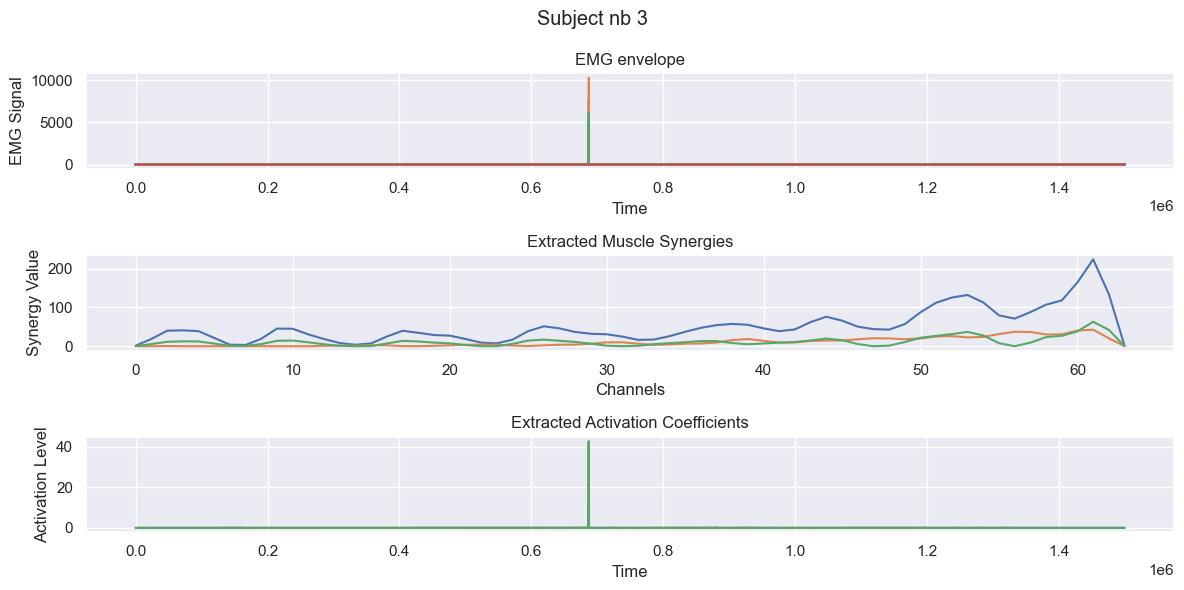

In [ ]:
i = 2
plot_synergies(envelope_subject[i], H_subject[i], W_subject[i], "Subject nb {}".format(i+1))


In [ ]:
for i in range(3):
    print("size is {}".format(envelope_subject[i].shape))

size is (1500000, 64)
size is (1500000, 64)
size is (1500000, 64)


## Part 5
<span style="color:green">
*Try to vary the frequencies used in the preprocessing step. Compute the spatial
synergies again. Does the choice of filtering frequencies affects the stability of the
synergies?*</span>

In [ ]:
frequencies = [(5,500), (50, 5000), (100, 10000), (200, 20000)]
BSS = "NMF"

W_freq: list = []
H_freq: list = []
envelope_freq: list = []

for frequency in frequencies:

    emg_envelope, adjusted_class, adjusted_repetition = preprocess_data(sub=i, sub_files=sub_files, Wn=frequency)
    envelope_freq.append(emg_envelope)
    
    if BSS == "NMF":
        model = NMF(n_components=3, init="nndsvda", max_iter=500)
    elif BSS == "PCA":
        model = PCA(n_components=3) 
    elif BSS == "ICA":
        model = FastICA(n_components=3)
    model.fit(emg_envelope)
    
    W_freq.append(model.fit_transform(emg_envelope))
    H_freq.append(model.components_)
    

In [ ]:
for i in range(n_subject):
    plot_synergies(envelope_freq[i], H_freq[i], W_freq[i], "Frequency band {}".format(frequencies[i]))

## Part 6
<span style="color:green">

*Evaluate the stability of the synergies across the different BSS algorithms with
respect to the tasks 3-4-5. Which algorithm performs better, and which one is least
stable. Discuss the pros and cons of the different algorithms.
*</span>
